## Interpolation Test Stimuli Performance V2

Two objectives:
- Training Data
- Model comparison
    - collapsed, and by individual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from behav import plotting, utils, loading
from starling_rhythm.utils.analysis import stim_parser, plot_subject_acquisition, acquisition_data_preprocessing

from starling_rhythm.utils.paths import PROCESSED_DIR
import pandas as pd

import seaborn as sns
sns.set_style("ticks")

data_path = '/mnt/cube/RawData/Magpi/'

subjects = (
    ['B1520', 'B1535']
)

/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
%%time
behav_data = loading.load_data_pandas(subjects, data_path)

CPU times: user 1.3 s, sys: 139 ms, total: 1.44 s
Wall time: 11.9 s


### Clean out debug trials before shaping and parse stim info

In [3]:
behav_data['B1520'] = behav_data['B1520'][behav_data['B1520'].index > '2023-01-19 00:00:00.000000'] 
## B1520 started trials on the 19th, previous are debug trials

behav_data['B1535'] = behav_data['B1535'][behav_data['B1535'].index > '2023-01-20 00:00:00.000000'] 
## B1535 started trials on the 20th, previous are debug trials

In [4]:
behav_data = stim_parser(behav_data)

Output stim labels for B1520: 107865it [00:10, 10273.59it/s]
Output stim labels for B1535: 101352it [00:08, 11464.88it/s]


## Plot acquisition data

Plot accuracy (y) over time (x) for each stimuli

/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[subj]['day'] = [
/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[subj]['day'] = [


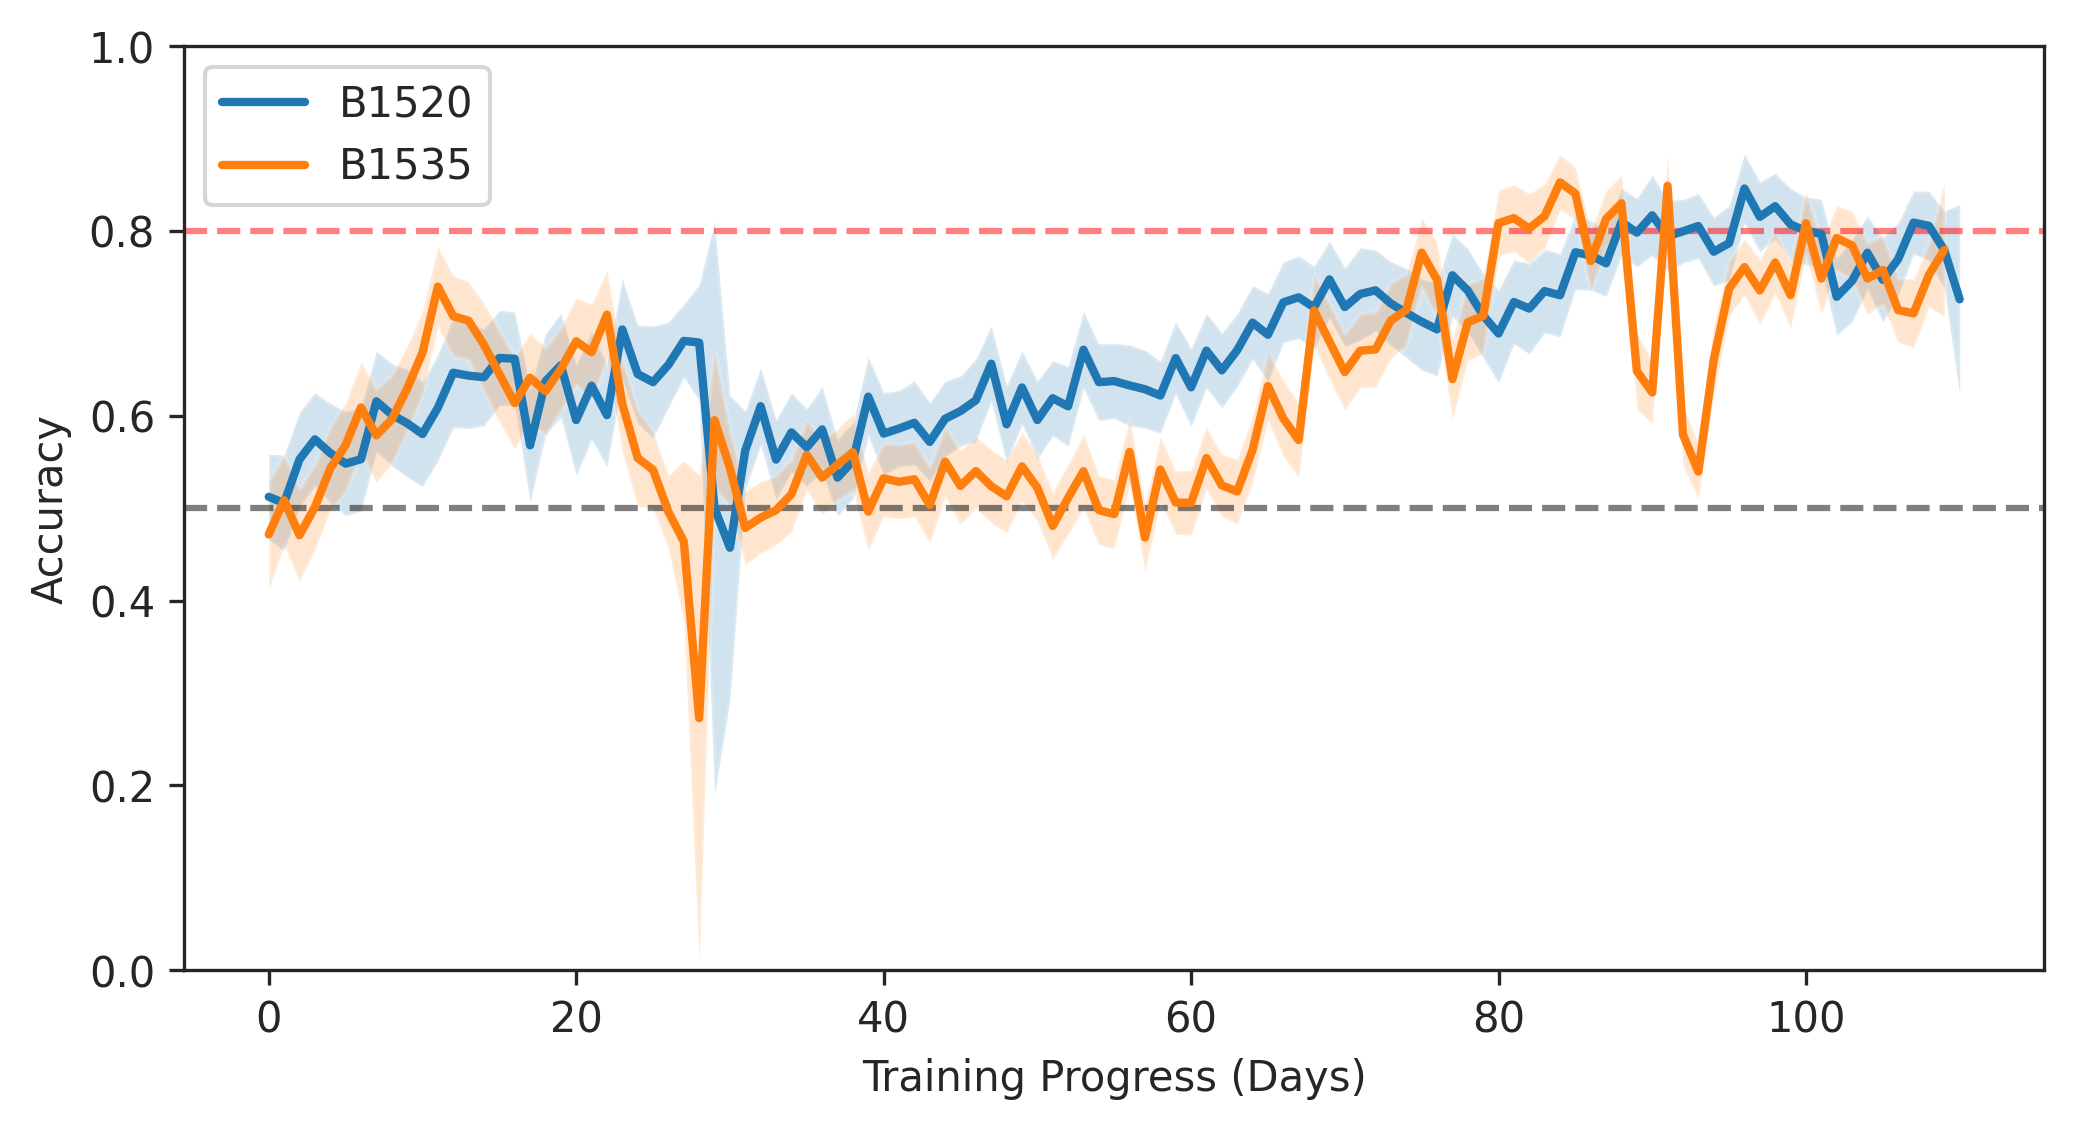

In [5]:
plot_subject_acquisition(behav_data)

show average performance before test stimuli

### For every test trial, only keep if the previous 100 trial accuracy is > 0.8

In [6]:
from starling_rhythm.utils.analysis import test_filter

In [7]:
test_data, training_data = test_filter(behav_data, accuracy_threshold = 0.8, past_baseline_trials = 100)

Iterating through test trials for subject B1520: 3741it [00:02, 1391.98it/s]
Iterating through test trials for subject B1535: 2637it [00:01, 1799.76it/s]


### Hypothesis Space

Hypothesis 1: Linear Interpolation 

Hypothesis 2: Multifractal

In [8]:
bID = "s_b1555_22"
SAVE_PATH = PROCESSED_DIR / bID / 'salvage_inter_tmf.pickle'
stims = pd.read_pickle(SAVE_PATH)

In [9]:
grouped_training_data = pd.concat(training_data)

In [10]:
baseline_accuracies = pd.DataFrame(
    grouped_training_data.groupby(
        ['inter_nums']
    )['response'].agg('value_counts', normalize = True)
)

baseline_accuracies = baseline_accuracies.rename(columns = {'response': 'prop'})

In [11]:
baseline_accuracies.loc[('max', 'right')].values[0]

0.11672583002714554

In [12]:
baseline_accuracies

prop
inter_nums response          
max        left      0.843182
           right     0.116726
           none      0.040092
min        right     0.713643
           left      0.235222
           none      0.051135

In [13]:
stims.groupby('interpolation_num')['mean_tMF'].agg('mean').iloc[-1]

23.525071394807533

In [14]:
mf_function = list(stims.groupby('interpolation_num')['mean_tMF'].agg('mean')[::4].values)

In [15]:
list(stims.groupby('interpolation_num')['mean_tMF'].agg('mean')[::4].index.values).append(127)

normalize(
    x = np.linspace(1, 0, 33), 
    normalize_anchors = (np.linspace(1, 0, 33)[0], np.linspace(1, 0, 33)[-1]), 
    newRange = (left_baseline, right_baseline)
)

In [16]:
mf_function.append(stims.groupby('interpolation_num')['mean_tMF'].agg('mean').iloc[-1])

In [17]:
def normalize(x, normalize_anchors, newRange=(0, 1)): #x is an array. Default range is between zero and one
    xmin, xmax = normalize_anchors #get max and min from input array
    norm = (x - xmin)/(xmax - xmin) # scale between zero and one
    
    if newRange == (0, 1):
        return(norm) # wanted range is the same as norm
    elif newRange != (0, 1):
        return norm * (newRange[1] - newRange[0]) + newRange[0] #scale to a different range.    
    #add other conditions here. For example, an error message

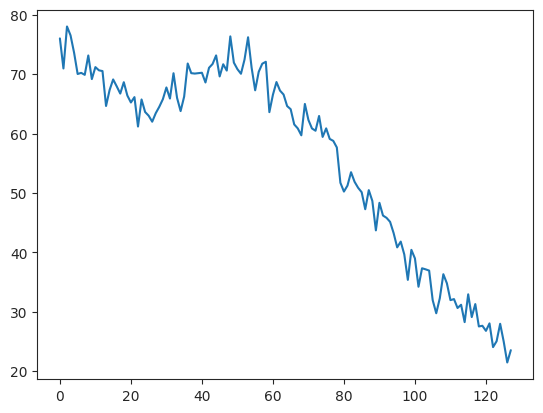

In [18]:
plt.plot(stims.groupby('interpolation_num')['mean_tMF'].agg('mean'))

In [19]:
what = pd.DataFrame({
    'mf' : hypo1_mf[0],
    'p' : hypo1_mf[1]
}).sort_values(by = 'mf')

NameError: name 'hypo1_mf' is not defined

In [20]:
baseline_accuracies

prop
inter_nums response          
max        left      0.843182
           right     0.116726
           none      0.040092
min        right     0.713643
           left      0.235222
           none      0.051135

Text(0.02, 0.5, 'Prop. of Response to high TMF')

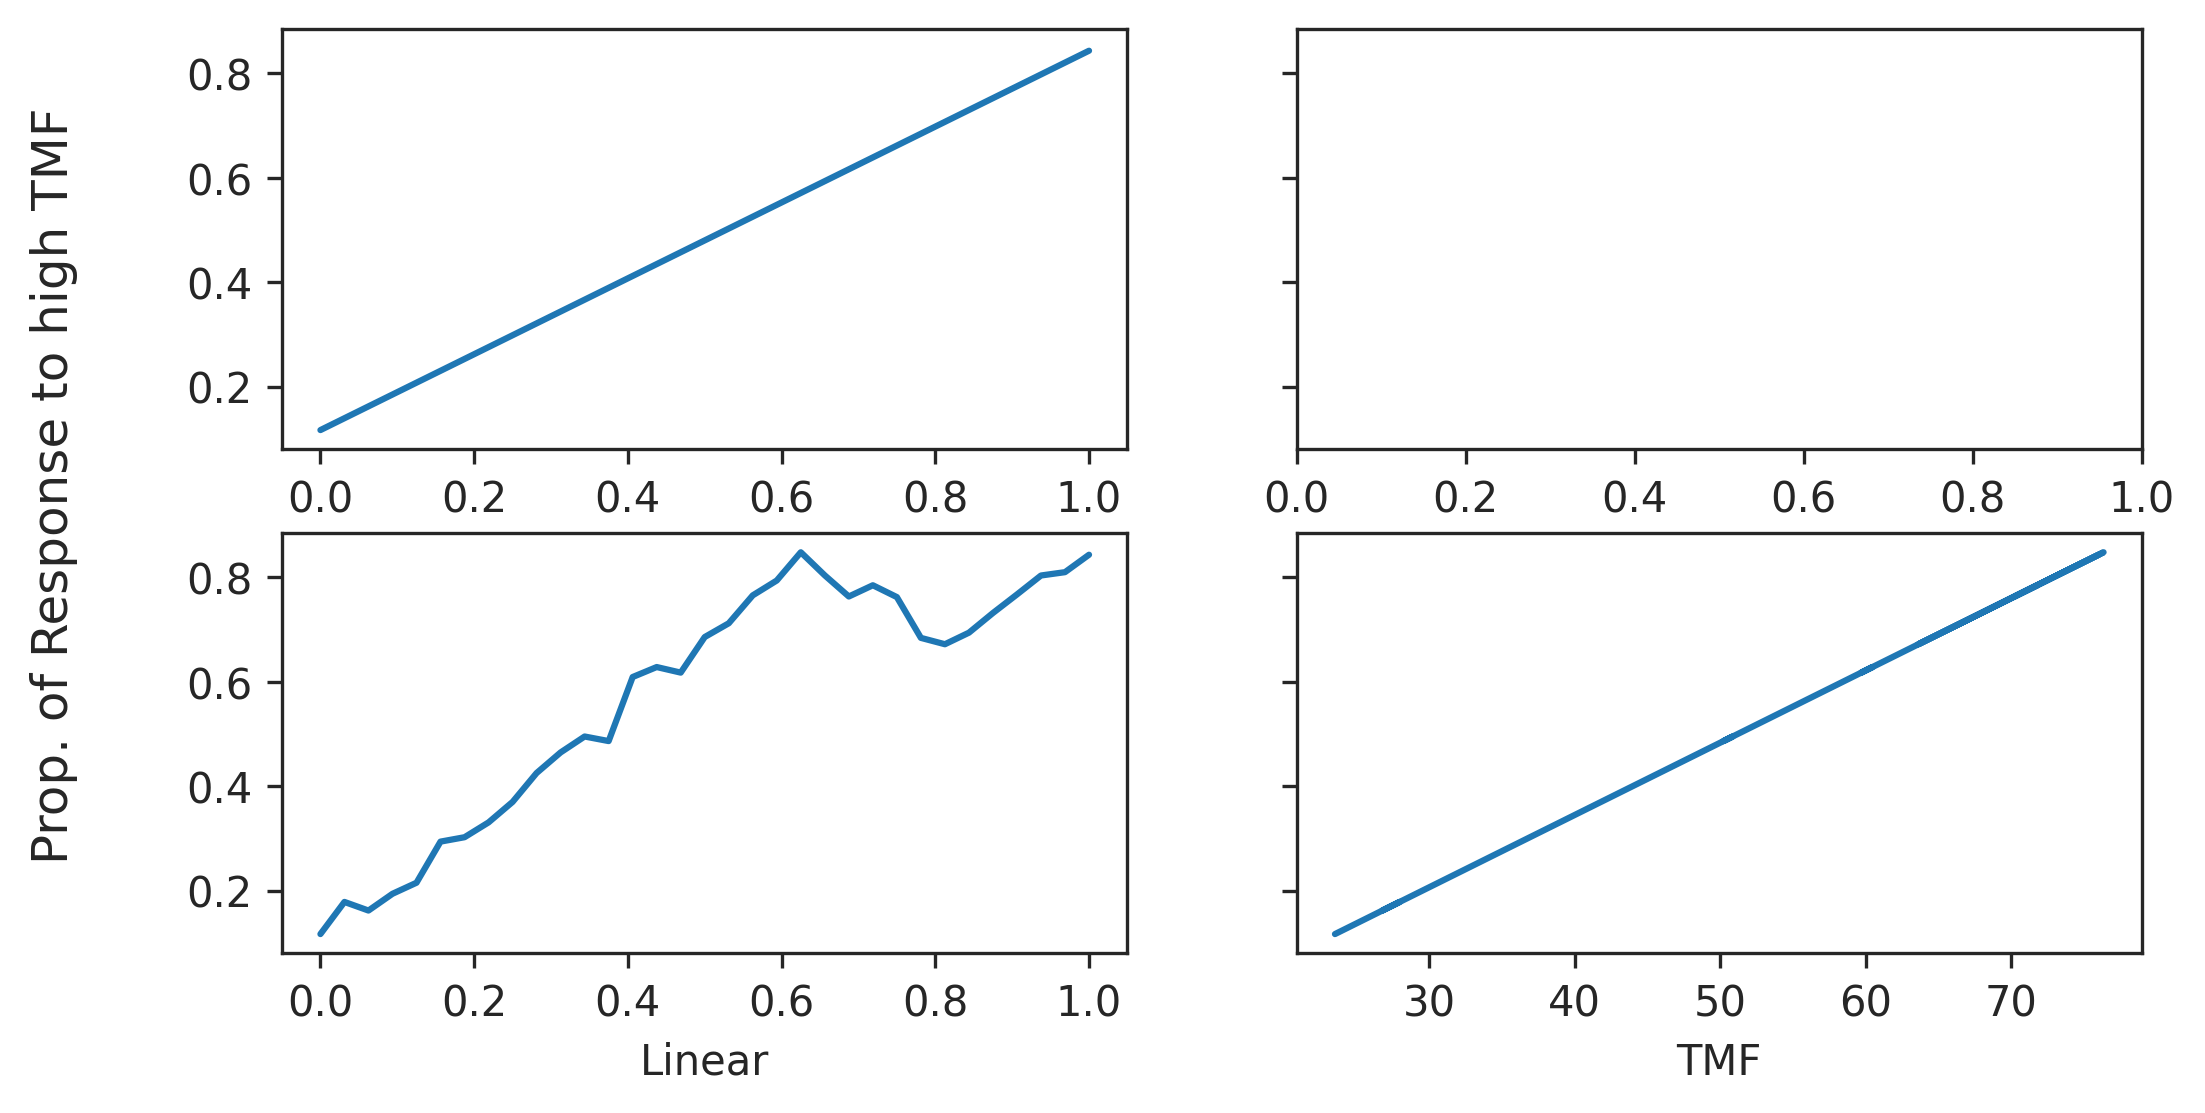

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = False, sharey = True, figsize = (8, 4), dpi = 300)

left_baseline = baseline_accuracies.loc[('max', 'left')].values[0]
right_baseline = baseline_accuracies.loc[('max', 'right')].values[0]


## Hypothesis 1
### From left baseline to right baseline, there is a linear relationship in the linear interpolation space
hypo1_linear = (
    np.linspace(1, 0, 33), 
    np.linspace(left_baseline, right_baseline, 33)
)

### From left baseline to right baseline, there is undefined relationship in the multifractal space
hypo1_mf = (
    mf_function,
    normalize(
        x = np.linspace(1, 0, 33), 
        normalize_anchors = (np.linspace(1, 0, 33)[0], np.linspace(1, 0, 33)[-1]), 
        newRange = (left_baseline, right_baseline)
    )
)

axes[0][0].plot(
    hypo1_linear[0], 
    hypo1_linear[1]
)

#axes[0][1].plot(
#    what['mf'],
#    what['p']
#)

axes[0][0].set_xlabel('Linear')
axes[0][1].set_xlabel('Linear')
axes[1][0].set_xlabel('Linear')
axes[1][1].set_xlabel('TMF')

## Hypothesis 2
### from left baseline to right baseline, there is a linear relationship in the multifractal space
hypo2_linear = (
    np.linspace(1, 0, 33),
    normalize(
        x = mf_function, 
        normalize_anchors = (mf_function[0], mf_function[-1]), 
        newRange = (left_baseline, right_baseline)
    )
)

### from left baseline to right baseline, there is an undefined relationship in the multifractal space
hypo2_mf = (
    mf_function,
    normalize(
        x = mf_function, 
        normalize_anchors = (mf_function[0], mf_function[-1]), 
        newRange = (left_baseline, right_baseline)
    )
)

axes[1][0].plot(
    hypo2_linear[0],
    hypo2_linear[1]
)

axes[1][1].plot(
    hypo2_mf[0],
    hypo2_mf[1]
)

fig.supylabel('Prop. of Response to high TMF')

## 

In [22]:
## plot

In [23]:
test_data = pd.concat(test_data)

In [24]:
test_data

time session index type_  \
B1520 86177  2023-04-19 12:46:10.018781       1   129  test   
      86207  2023-04-19 13:21:46.445657       1    15  test   
      86209  2023-04-19 13:22:22.555339       1    17  test   
      86218  2023-04-19 13:32:58.822093       1    26  test   
      86221  2023-04-19 13:35:31.927146       1    29  test   
...                                 ...     ...   ...   ...   
B1535 100573 2023-05-08 13:31:07.116005      32    55  test   
      100584 2023-05-08 13:36:49.229246      32    66  test   
      100585 2023-05-08 13:37:07.628943      32    67  test   
      100616 2023-05-08 14:01:48.309596      32    98  test   
      100617 2023-05-08 14:02:05.618901      32    99  test   

                                                       stimulus class_  \
B1520 86177   /home/bird/opdat/B1520/salv_interpolate/shuffl...      L   
      86207   /home/bird/opdat/B1520/salv_interpolate/shuffl...      L   
      86209   /home/bird/opdat/B1520/salv_interpolate/shuffl...      R   
      86218   /home/bird/opdat/B1520/salv_interpolate/shuffl...      R   
      86221   /home/bird/opdat/B1520/salv_interpolate/shuffl...      R   
...                                                         ...    ...   
B1535 100573  /home/bird/opdat/B1535/salv_interpolate/shuffl...      L   
      100584  /home/bird/opdat/B1535/salv_interpolate/shuffl...      R   
      100585  /home/bird/opdat/B1535/salv_interpolate/shuffl...      L   
      100616  /home/bird/opdat/B1535/salv_interpolate/shuffl...      R   
      100617  /home/bird/opdat/B1535/salv_interpolate/shuffl...      L   

             response correct        rt  reward punish  \
B1520 86177      left    True  0.203984   False  False   
      86207      left    True  0.219528   False  False   
      86209      left   False  0.235141   False  False   
      86218      left   False  3.514493   False  False   
      86221      left   False  0.204056   False  False   
...               ...     ...       ...     ...    ...   
B1535 100573    right   False  0.578117   False  False   
      100584    right    True  2.278777   False  False   
      100585     left    True  0.750254   False  False   
      100616    right    True  1.173060   False  False   
      100617     left    True  0.874719   False  False   

                                                      data_file stim_type  \
B1520 86177   /mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...     INTER   
      86207   /mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...     INTER   
      86209   /mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...     INTER   
      86218   /mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...     INTER   
      86221   /mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...     INTER   
...                                                         ...       ...   
B1535 100573  /mnt/cube/RawData/Magpi/B1535/B1535_trialdata_...     INTER   
      100584  /mnt/cube/RawData/Magpi/B1535/B1535_trialdata_...     INTER   
      100585  /mnt/cube/RawData/Magpi/B1535/B1535_trialdata_...     INTER   
      100616  /mnt/cube/RawData/Magpi/B1535/B1535_trialdata_...     INTER   
      100617  /mnt/cube/RawData/Magpi/B1535/B1535_trialdata_...     INTER   

             pair_indices inter_nums  
B1520 86177             1         20  
      86207             1         28  
      86209             1         76  
      86218             1        116  
      86221             0         72  
...                   ...        ...  
B1535 100573            1         48  
      100584            1        112  
      100585            0         44  
      100616            1         92  
      100617            1         44  

[2309 rows x 15 columns]

In [25]:
PMFX = pd.DataFrame(test_data.groupby(
    'inter_nums'
)['response'].agg('value_counts', normalize = True))
PMFX = PMFX.rename(columns = {'response': 'prop'})

In [26]:
PMFX

prop
inter_nums response          
0          left      0.850746
           right     0.119403
           none      0.029851
4          left      0.855263
           right     0.092105
...                       ...
124        right     0.690141
           left      0.267606
           none      0.042254
127        right     0.571429
           left      0.428571

[97 rows x 1 columns]

In [27]:
PMFX = PMFX.reset_index()

In [28]:
PMFX_L = PMFX[PMFX.response == 'left'].drop([0])
PMFX_L.loc[0] = {
    'inter_nums': 0, 
    'response': 'left',
    'prop': left_baseline
}
PMFX_L.loc[127] = {
    'inter_nums': 127, 
    'response': 'left',
    'prop': right_baseline
}

In [29]:
PMFX_L = PMFX_L.reset_index(drop = True)

In [30]:
PMFX_L['rank'] = PMFX_L['inter_nums'].rank(ascending = False)
PMFX_L = PMFX_L.sort_values(by = 'rank')
PMFX_L['inter_degree'] = np.linspace(0, 1, 33)

ValueError: Length of values (33) does not match length of index (34)

In [ ]:
PMFX_L.reset_index(drop = True)

In [ ]:
go back and listen to the test stimuli

In [52]:
plt.figure(figsize = (16, 4), dpi = 300)
sns.scatterplot(
    data = PMFX_L,
    x = 'inter_degree',
    y = 'prop',
    label = 'Test Stimuli'
)

plt.plot(
    hypo1_linear[0],
    hypo1_linear[1],
    label = 'hypothesis 1: linear interpolation'
)

plt.plot(
    hypo2_linear[0],
    hypo2_linear[1],
    label = 'hypothesis 2: multifractal perception'
)

plt.plot(1, left_baseline, marker = 'o', markerfacecolor = 'green', markeredgecolor = 'green', markersize = 10, label = 'Baseline Accuracy')
plt.plot(0, right_baseline, marker = 'o', markerfacecolor = 'green', markeredgecolor = 'green', markersize = 10)

plt.legend()

ValueError: Could not interpret value `inter_degree` for parameter `x`

<Figure size 4800x1200 with 0 Axes>

In [ ]:
hypo1_linear[0]

In [31]:
np.flip(hypo2_linear[1])

array([0.11672583, 0.17827699, 0.16178562, 0.19387205, 0.21504842,
       0.29379083, 0.30220688, 0.33059651, 0.36978277, 0.4251375 ,
       0.4645637 , 0.49508435, 0.48632595, 0.60900318, 0.62809534,
       0.61742502, 0.68556484, 0.71189593, 0.76539216, 0.79385501,
       0.8479181 , 0.80358041, 0.76320668, 0.78471885, 0.76204099,
       0.6839513 , 0.67177832, 0.69390621, 0.73161153, 0.7671083 ,
       0.8034069 , 0.80980247, 0.84318229])

In [32]:
PMFX_L['linear_pred'] = np.flip(hypo1_linear[1])

ValueError: Length of values (33) does not match length of index (34)

In [50]:
PMFX_L['mf_pred'] = np.flip(hypo2_linear[1])

ValueError: Length of values (33) does not match length of index (34)

In [51]:
PMFX_L

,inter_nums,response,prop,rank
33,127,left,0.116726,1.5
31,127,left,0.428571,1.5
30,124,left,0.267606,3.0
29,120,left,0.291667,4.0
28,116,left,0.356164,5.0
27,112,left,0.228571,6.0
26,108,left,0.366197,7.0
25,104,left,0.283333,8.0
24,100,left,0.250000,9.0
23,96,left,0.315068,10.0


## calculate R^2

In [48]:
from sklearn.metrics import r2_score

In [49]:
r2_score(PMFX_L['prop'], PMFX_L['linear_pred'])

KeyError: 'linear_pred'

In [ ]:
r2_score(PMFX_L['prop'], PMFX_L['mf_pred'])

## chi square

In [37]:
import scipy.stats

In [38]:
linear_exp = (PMFX_L['linear_pred'].values * CHI_count['total']).values[1:-1]
linear_exp = linear_exp * (sum((PMFX_L['prop'].values[1:-1] * CHI_count['total'][1:-1]).astype(int))/ sum(linear_exp))
linear_exp

KeyError: 'linear_pred'

In [ ]:
mf_exp = (PMFX_L['mf_pred'].values * CHI_count['total']).values[1:-1]
mf_exp = mf_exp * (sum((PMFX_L['prop'].values[1:-1] * CHI_count['total'][1:-1]).astype(int))/ sum(mf_exp))

In [39]:
scipy.stats.chisquare(
    f_obs = (PMFX_L['prop'].values * CHI_count['total']).astype(int)[1:-1],
    f_exp = linear_exp
)

NameError: name 'CHI_count' is not defined

In [40]:
scipy.stats.chisquare(
    f_obs = (PMFX_L['prop'].values * CHI_count['total']).astype(int)[1:-1],
    f_exp = mf_exp
)

NameError: name 'CHI_count' is not defined

In [41]:
CHI_count = pd.DataFrame(test_data.groupby(
    ['inter_nums']
)['response'].agg(
    total = 'count'
)).reset_index()

In [42]:
CHI_count = CHI_count.drop(0)

In [43]:
CHI_count.loc[0] = {
    'inter_nums': 0,
    'total': pd.DataFrame(grouped_training_data.groupby(
        ['inter_nums']
    )['response'].agg('count')).loc['max'][0]
}
CHI_count.loc[127] = {
    'inter_nums': 127,
    'total': pd.DataFrame(grouped_training_data.groupby(
        ['inter_nums']
    )['response'].agg('count')).loc['max'][0]
}

In [44]:
pd.DataFrame(grouped_training_data.groupby(
        ['inter_nums']
    )['response'].agg('count'))

,response
inter_nums,
max,4789
min,4889


In [45]:
grouped_training_data.groupby(
    'inter_nums'
)['response'].agg('count')

inter_nums
max    4789
min    4889
Name: response, dtype: int64

In [46]:
PMFX_L['prop'].values * CHI_count['total']

1         8.871163
2        24.428571
3        23.281690
4        20.125000
5        26.712329
6        14.400000
7        31.126761
8        18.416667
9        20.500000
10       20.479452
11       15.413333
12       17.692308
13       26.400000
14       21.677419
15       32.500000
16       36.606557
17       31.000000
18       31.688312
19       30.769231
20       32.937500
21       36.363636
22       42.956522
23       40.808824
24       49.415385
25       45.414634
26       38.769231
27       46.776471
28       48.888889
29       53.533333
30       52.173913
31       48.149425
32        4.789474
0      4095.855263
127    4038.000000
Name: total, dtype: float64

In [47]:
CHI_count = CHI_count.sort_values(by = 'inter_nums', ascending = False)

## Reaction time?

In [ ]:
test_rt = pd.DataFrame(test_data.groupby(
    ['correct', 'inter_nums', 'pair_indices']
)['rt'].agg('mean'))

In [ ]:
test_rt

In [ ]:
sns.lineplot(data = test_rt, x = 'inter_nums', y = 'rt', hue = 'correct')

In [ ]:
## by subject?
test_1520 = pd.DataFrame(test_data.loc['B1520'].groupby(
    ['correct', 'inter_nums', 'pair_indices']
)['rt'].agg('mean'))

In [ ]:
sns.lineplot(data = test_1520, x = 'inter_nums', y = 'rt', hue = 'correct')

In [ ]:
## by subject?
test_1535 = pd.DataFrame(test_data.loc['B1535'].groupby(
    ['correct', 'inter_nums', 'pair_indices']
)['rt'].agg('mean'))

In [ ]:
sns.lineplot(data = test_1535, x = 'inter_nums', y = 'rt', hue = 'correct')